In this python notebook, we will go through a set of data engineering and data analytics processes on 3 different datasets.

The process will include the following steps:

1.0) Data Preprocessing.

2.1) Model Implementation (Random Forest)

2.2) Hyperparameter tuning for the model.

2.3) Training and evaluation of the model.


3.1) Model Implementation (AdaBoost)

3.2) Hyperparameter tuning for the model.

3.3) Training and evaluation of the model.


4.1) Model Implementation (Gradient Boost)

4.2) Hyperparameter tuning for the model.

4.3) Training and evaluation of the model.


5.0) Comparison Table.

6.0) Visualization.

7.0) Insight and Conslusion.

## Imports

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error

#Importing Random Forest, AdaBoost, and Gradient Boost models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score

##### Some Predefined Functions:

In [24]:
# This function shows the performance metrics for a given model

def evaluate(bestModel, y_test_input, X_test_input):
    # Creating a confusion matrix
    conf_matrix = confusion_matrix(y_test_input, bestModel.predict(X_test_input))

    # Reference: https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6
    # Calculate the accuracy, precision, recall, and f1 score of the model
    bestModelAccuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
    bestModelPrecision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    bestModelRecall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    bestModelF1Score = 2 * (bestModelPrecision * bestModelRecall) / (bestModelPrecision + bestModelRecall)

    print('Best Classifier Accuracy:', bestModelAccuracy)
    print('Best Classifier Precision:', bestModelPrecision)
    print('Best Classifier Recall:', bestModelRecall)
    print('Best Classifier F1 Score:', bestModelF1Score)

    # Plot the heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [25]:
def evaluateRegrission(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')
    
    r2 = r2_score(y_test, predictions)
    print(f'R-squared: {r2}')

    abs_error = mean_absolute_error(y_test, predictions)
    print(f'Mean Absolute Error: {abs_error}')

---------------------------------------
# First Database Data Engineering Process

Database name: "bankloan.csv"

In [26]:
df1 = pd.read_csv('bankloan.csv')

In [27]:
df1.head()

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## 1.0) Data Preprocessing

##### Checking null values for each column.

In [28]:
# Get the number of null values for each column
null_values = df1.isnull().sum()
print(null_values)

# We have no null values!

ID                    0
Age                   0
Experience            0
Income                0
ZIP.Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal.Loan         0
Securities.Account    0
CD.Account            0
Online                0
CreditCard            0
dtype: int64


##### Normalize the "Zip.Code" column to contain values between 0 and 1 only, using the MinMaxScaler library. 

In [29]:
scaler = MinMaxScaler()

# Extract the column to be normalized
column_data = df1[['ZIP.Code']]

# Apply MinMax scaling to the extracted column
normalized_column_data = scaler.fit_transform(column_data)

# Replace the original column with the normalized values
df1['ZIP.Code'] = normalized_column_data

In [30]:
df1.head()

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,0.936527,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,0.924872,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,0.977892,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,0.970931,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,0.939080,4,1.0,2,0,0,0,0,0,1


##### Drop any irrelevant columns.

In [31]:
# We will drop the "ID" column so it is not considered into the Mashine Learning algorithms.
df1.drop(columns=['ID'], inplace=True)

In [32]:
df1.head()

,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,25,1,49,0.936527,4,1.6,1,0,0,1,0,0,0
1,45,19,34,0.924872,3,1.5,1,0,0,1,0,0,0
2,39,15,11,0.977892,1,1.0,1,0,0,0,0,0,0
3,35,9,100,0.970931,1,2.7,2,0,0,0,0,0,0
4,35,8,45,0.939080,4,1.0,2,0,0,0,0,0,1


## 2.1) Random Forest model implementation

In [33]:
# Split the data into features and target label
X1 = df1.drop('Personal.Loan', axis=1)
y1 = df1['Personal.Loan']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [34]:
# Creating a random forest classifier
rfcModel = RandomForestClassifier(n_estimators=100, random_state=42)

rfcModel.fit(X_train1, y_train1)

rfcPredictions = rfcModel.predict(X_test1)

# Calculate the accuracy of the model
rfcAccuracy = accuracy_score(y_test1, rfcPredictions)
print('Random Forest Classifier Accuracy:', rfcAccuracy)

Random Forest Classifier Accuracy: 0.99


## 2.2) Hyperparameter tuning for the Random Forest model

In [35]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridRFC = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfc = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_searchRFC = GridSearchCV(estimator=rfc, param_grid=param_gridRFC, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchRFC.fit(X_train1, y_train1)

# Print the best parameters
print(grid_searchRFC.best_params_)
print(grid_searchRFC.best_estimator_)
print(grid_searchRFC.best_score_)


# The results:

# Best Params: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
# Classifier: RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=300, random_state=42)
# Score: 0.9854989984377654

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
972 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
543 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\most2\anaconda3\Lib\site-packa

{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=300,
                       random_state=42)
0.9854989984377654


## 2.3) Evaluation of the Random Forest model

Best Classifier Accuracy: 0.991
Best Classifier Precision: 0.98
Best Classifier Recall: 0.9333333333333333
Best Classifier F1 Score: 0.9560975609756097


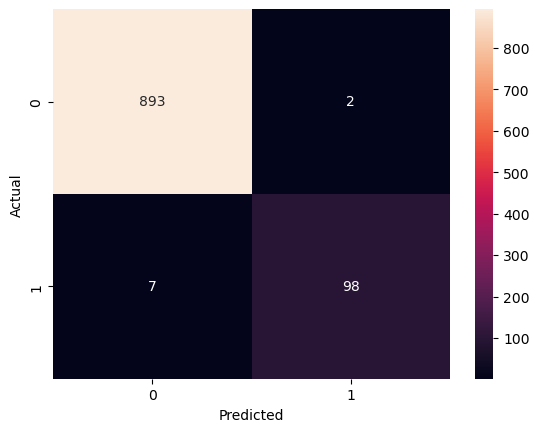

In [36]:
bestRFCModel = grid_searchRFC.best_estimator_
evaluate(bestRFCModel, y_test1, X_test1)

## 3.1) AdaBoost model implementation

In [37]:
# Creating a AdaBoost classifier
abcModel = AdaBoostClassifier(n_estimators=100, random_state=42)

abcModel.fit(X_train1, y_train1)

abcPredictions = abcModel.predict(X_test1)

# Calculate the accuracy of the model
abcAccuracy = accuracy_score(y_test1, abcPredictions)
print('AdaBoost Classifier Accuracy:', abcAccuracy)

AdaBoost Classifier Accuracy: 0.97


## 3.2) Hyperparameter tuning for the AdaBoost model

In [38]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridABC = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]
}

# Create a base model
abcModel = AdaBoostClassifier(random_state=42)

# Instantiate the grid search model
grid_searchABC = GridSearchCV(estimator=abcModel, param_grid=param_gridABC, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchABC.fit(X_train1, y_train1)

# Print the best parameters
print(grid_searchABC.best_params_)
print(grid_searchABC.best_estimator_)
print(grid_searchABC.best_score_)


# The results:

# {'learning_rate': 0.1, 'n_estimators': 200}
# AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
# 0.9662513079544249

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'learning_rate': 0.1, 'n_estimators': 200}
AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
0.9662513079544249


## 3.3) Evaluation of the AdaBoost model

Best Classifier Accuracy: 0.97
Best Classifier Precision: 0.9518072289156626
Best Classifier Recall: 0.7523809523809524
Best Classifier F1 Score: 0.8404255319148937


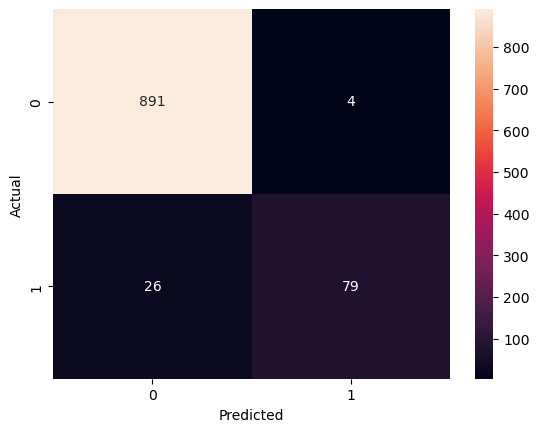

In [39]:
evaluate(grid_searchABC.best_estimator_, y_test1, X_test1)

## 4.1) Gradient Boost model implementation

In [40]:
# Creating a Gradient Boost classifier
gbcModel = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbcModel.fit(X_train1, y_train1)

gbcPredictions = gbcModel.predict(X_test1)

# Calculate the accuracy of the model
gbcAccuracy = accuracy_score(y_test1, gbcPredictions)
print('Gradient Boost Classifier Accuracy:', abcAccuracy)

Gradient Boost Classifier Accuracy: 0.97


## 4.2) Hyperparameter tuning for the Gradient Boost model

In [41]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridGBC = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a base model
gbcModel = GradientBoostingClassifier(random_state=42)

# Instantiate the grid search model
grid_searchGBC = GridSearchCV(estimator=gbcModel, param_grid=param_gridGBC, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchGBC.fit(X_train1, y_train1)

# Print the best parameters
print(grid_searchGBC.best_params_)
print(grid_searchGBC.best_estimator_)
print(grid_searchGBC.best_score_)


# The results:

# {'learning_rate': 0.3, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
# GradientBoostingClassifier(learning_rate=0.3, max_features='sqrt',
#                            min_samples_split=10, random_state=42,
#                            subsample=0.8)
# 0.9859996858285037

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
755 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\most2\anaconda3\Lib\site-pack

{'learning_rate': 0.3, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
GradientBoostingClassifier(learning_rate=0.3, max_features='sqrt',
                           min_samples_split=10, random_state=42,
                           subsample=0.8)
0.9859996858285037


## 4.3) Evaluation of the Gradient Boost model

Best Classifier Accuracy: 0.992
Best Classifier Precision: 0.9801980198019802
Best Classifier Recall: 0.9428571428571428
Best Classifier F1 Score: 0.9611650485436893


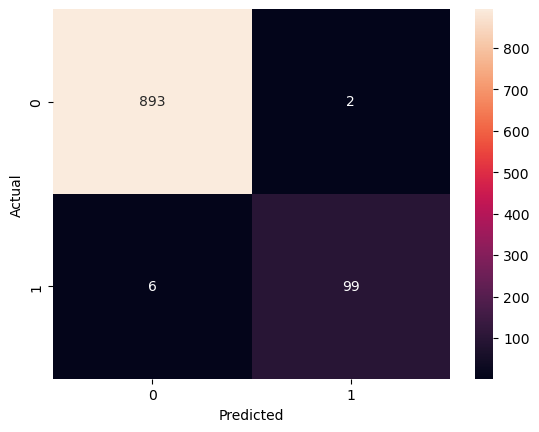

In [42]:
evaluate(grid_searchGBC.best_estimator_, y_test1, X_test1)

--------------------------------
# Second Database Data Engineering Process

Database name: "data_banknote_authentication.csv"

In [43]:
# Same exact code process as for the first database
df2 = pd.read_csv('data_banknote_authentication.csv')

In [44]:
df2.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 1.0) Data Preprocessing

##### Checking null values for each column.

In [45]:
# Get the number of null values for each column
null_values = df2.isnull().sum()
print(null_values)

# We have no null values!

Variance_Wavelet    0
Skewness_Wavelet    0
Curtosis_Wavelet    0
Image_Entropy       0
Class               0
dtype: int64


Checking for non numeric data

In [46]:
non_numeric_columns = df2.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

# We have no non-numeric columns!

Index([], dtype='object')


##### Normalize the columns to contain values between 0 and 1 only, using the MinMaxScaler library. 

In [47]:
scaler = MinMaxScaler()

# Extracting the column to be normalized
column_data = df2[['Variance_Wavelet', 'Skewness_Wavelet', 'Curtosis_Wavelet', 'Image_Entropy']]

# Apply MinMax scaling to the extracted column
normalized_column_data = scaler.fit_transform(column_data)

# Replacing the original column with the normalized values
df2['Variance_Wavelet'] = normalized_column_data[:, 0]
df2['Skewness_Wavelet'] = normalized_column_data[:, 1]
df2['Curtosis_Wavelet'] = normalized_column_data[:, 2]
df2['Image_Entropy'] = normalized_column_data[:, 3]

In [48]:
df2.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,0.769004,0.839643,0.106783,0.736628,0
1,0.835659,0.820982,0.121804,0.644326,0
2,0.786629,0.416648,0.310608,0.786951,0
3,0.757105,0.871699,0.054921,0.450440,0
4,0.531578,0.348662,0.424662,0.687362,0


##### Removing Outliers.

Curtosis_Wavelet    59
Image_Entropy       33
dtype: int64
(1372, 5)


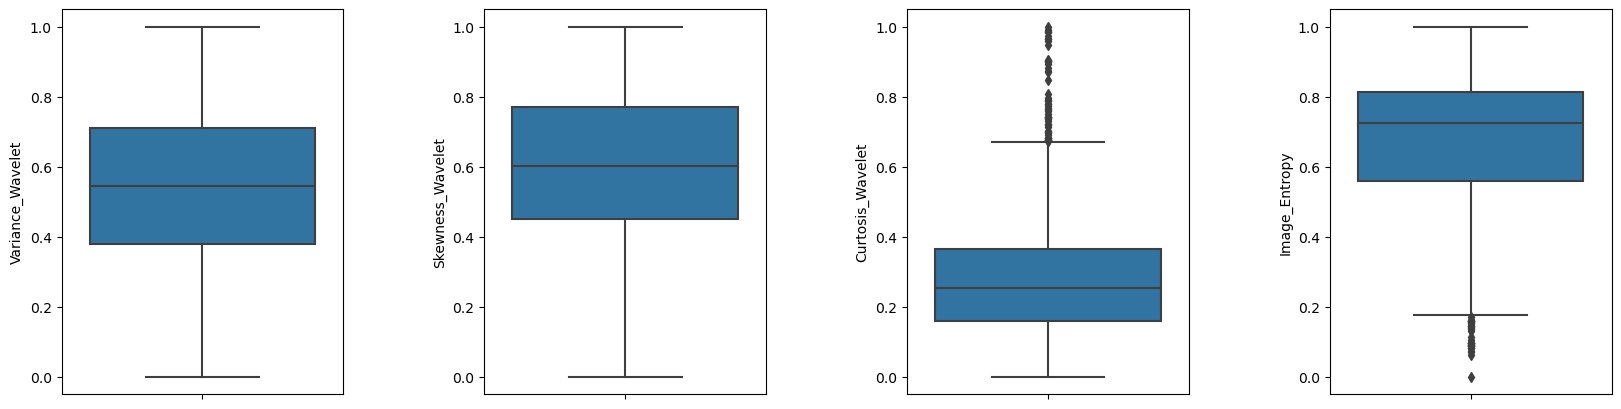

In [49]:
# Visualizing the data for outliers
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(y=df2['Variance_Wavelet'], ax=ax[0])
sns.boxplot(y=df2['Skewness_Wavelet'], ax=ax[1])
sns.boxplot(y=df2['Curtosis_Wavelet'], ax=ax[2])
sns.boxplot(y=df2['Image_Entropy'], ax=ax[3])
plt.subplots_adjust(wspace=0.5)

# Printing number of outliers
Q1 = df2[['Curtosis_Wavelet', 'Image_Entropy']].quantile(0.25)
Q3 = df2[['Curtosis_Wavelet', 'Image_Entropy']].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df2[['Curtosis_Wavelet', 'Image_Entropy']] < (Q1 - 1.5 * IQR)) | (df2[['Curtosis_Wavelet', 'Image_Entropy']] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

# We can see that there are outliers on columns Curtosis_Wavelet and Image_Entropy
print(df2.shape)

Curtosis_Wavelet    15
Image_Entropy       17
dtype: int64
(1280, 5)


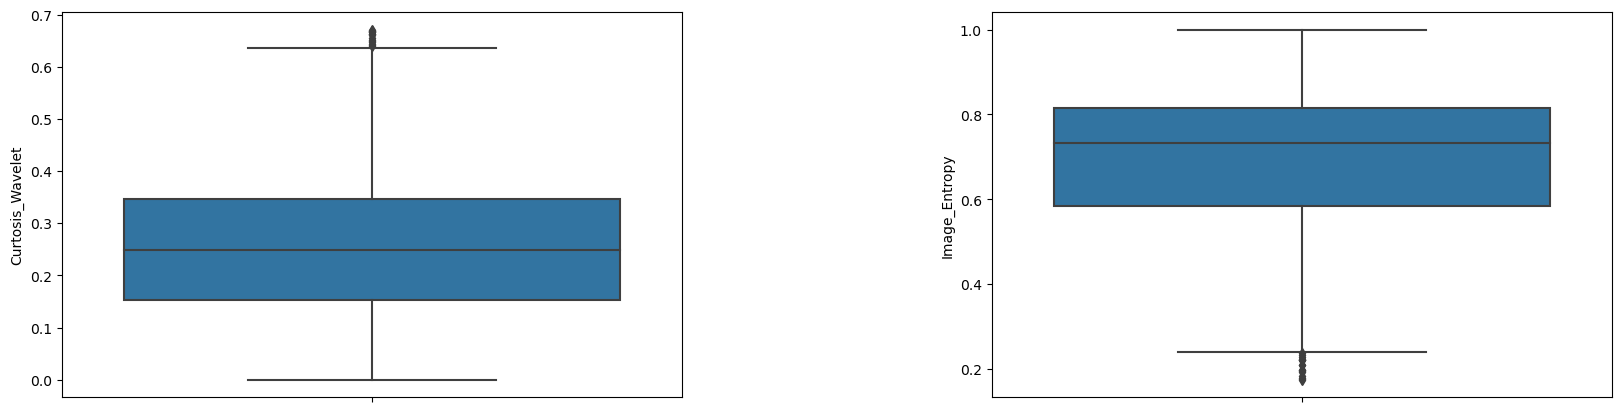

In [50]:
# Removing the outliers
df2 = df2[~((df2[['Curtosis_Wavelet', 'Image_Entropy']] < (Q1 - 1.5 * IQR)) | (df2[['Curtosis_Wavelet', 'Image_Entropy']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Visualizing the data for outliers again
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(y=df2['Curtosis_Wavelet'], ax=ax[0])
sns.boxplot(y=df2['Image_Entropy'], ax=ax[1])
plt.subplots_adjust(wspace=0.5)

# Printing number of outliers again
Q1 = df2[['Curtosis_Wavelet', 'Image_Entropy']].quantile(0.25)
Q3 = df2[['Curtosis_Wavelet', 'Image_Entropy']].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df2[['Curtosis_Wavelet', 'Image_Entropy']] < (Q1 - 1.5 * IQR)) | (df2[['Curtosis_Wavelet', 'Image_Entropy']] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

# Outliers have been reduced significantly
print(df2.shape)

## 2.1) Random Forest model implementation

In [51]:
# Split the data into features and target label
X2 = df2.drop('Class', axis=1)
y2 = df2['Class']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [52]:
# Creating a random forest classifier
rfcModel2 = RandomForestClassifier(n_estimators=100, random_state=42)

rfcModel2.fit(X_train2, y_train2)

rfcPredictions2 = rfcModel2.predict(X_test2)

# Calculate the accuracy of the model
rfcAccuracy2 = accuracy_score(y_test2, rfcPredictions2)
print('Random Forest Classifier Accuracy:', rfcAccuracy2)

Random Forest Classifier Accuracy: 0.9921875


## 2.2) Hyperparameter tuning for the Random Forest model

In [53]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridRFC2 = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfc2 = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_searchRFC2 = GridSearchCV(estimator=rfc2, param_grid=param_gridRFC2, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchRFC2.fit(X_train2, y_train2)

# Print the best parameters
print(grid_searchRFC2.best_params_)
print(grid_searchRFC2.best_estimator_)
print(grid_searchRFC2.best_score_)


# The results:
# Best Params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# Classifier: RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=200, random_state=42)
# Score: 0.9921912960962197

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
972 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
541 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\most2\anaconda3\Lib\site-packa

{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=200,
                       random_state=42)
0.9921912960962197


## 2.3) Evaluation of the Random Forest model

Best Classifier Accuracy: 0.99609375
Best Classifier Precision: 0.989247311827957
Best Classifier Recall: 1.0
Best Classifier F1 Score: 0.9945945945945946


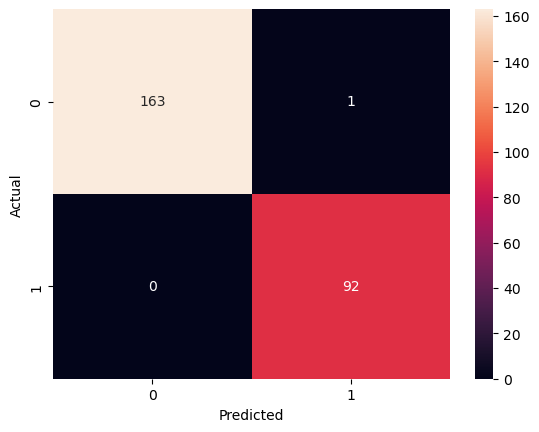

In [54]:
bestRFCModel2 = grid_searchRFC2.best_estimator_
evaluate(bestRFCModel2, y_test2, X_test2)

## 3.1) AdaBoost model implementation

In [55]:
# Creating a AdaBoost classifier
abcModel2 = AdaBoostClassifier(n_estimators=100, random_state=42)

abcModel2.fit(X_train2, y_train2)

abcPredictions2 = abcModel2.predict(X_test2)

# Calculate the accuracy of the model
abcAccuracy2 = accuracy_score(y_test2, abcPredictions2)
print('AdaBoost Classifier Accuracy:', abcAccuracy2)

# doesn't even need hyper parameter tuning :D

AdaBoost Classifier Accuracy: 1.0


## 3.2) Hyperparameter tuning for the AdaBoost model

In [56]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridABC2 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]
}

# Create a base model
abcModel2 = AdaBoostClassifier(random_state=42)

# Instantiate the grid search model
grid_searchABC2 = GridSearchCV(estimator=abcModel2, param_grid=param_gridABC2, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchABC2.fit(X_train2, y_train2)

# Print the best parameters
print(grid_searchABC2.best_params_)
print(grid_searchABC2.best_estimator_)
print(grid_searchABC2.best_score_)


# The results:

# {'learning_rate': 0.1, 'n_estimators': 200}
# AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
# 0.9970703069175055

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'learning_rate': 1, 'n_estimators': 200}
AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=42)
0.9970703069175055


## 3.3) Evaluation of the AdaBoost model

Best Classifier Accuracy: 1.0
Best Classifier Precision: 1.0
Best Classifier Recall: 1.0
Best Classifier F1 Score: 1.0


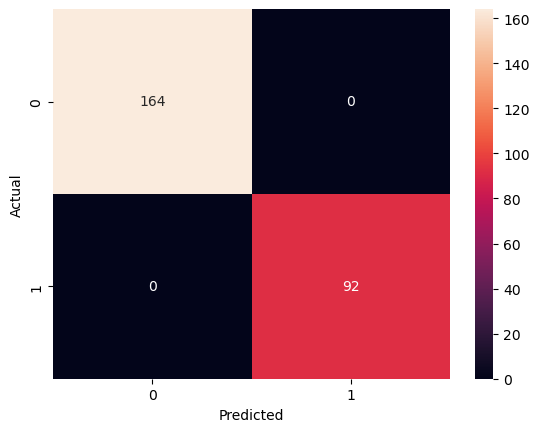

In [57]:
evaluate(grid_searchABC2.best_estimator_, y_test2, X_test2)

## 4.1) Gradient Boost model implementation

In [58]:
# Creating a Gradient Boost classifier
gbcModel2 = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbcModel2.fit(X_train2, y_train2)

gbcPredictions2 = gbcModel2.predict(X_test2)

# Calculate the accuracy of the model
gbcAccuracy2 = accuracy_score(y_test2, gbcPredictions2)
print('Gradient Boost Classifier Accuracy:', abcAccuracy2)

Gradient Boost Classifier Accuracy: 1.0


## 4.2) Hyperparameter tuning for the Gradient Boost model

In [59]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridGBC2 = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a base model
gbcModel2 = GradientBoostingClassifier(random_state=42)

# Instantiate the grid search model
grid_searchGBC2 = GridSearchCV(estimator=gbcModel2, param_grid=param_gridGBC2, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchGBC2.fit(X_train2, y_train2)

# Print the best parameters
print(grid_searchGBC2.best_params_)
print(grid_searchGBC2.best_estimator_)
print(grid_searchGBC2.best_score_)


# The results:

# {'learning_rate': 1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
# GradientBoostingClassifier(learning_rate=1, max_features='sqrt',
#                            min_samples_leaf=2, min_samples_split=5,
#                            random_state=42, subsample=0.8)
# 0.9980478240240549

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
605 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\most2\anaconda3\Lib\site-pack

{'learning_rate': 1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
GradientBoostingClassifier(learning_rate=1, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=5,
                           random_state=42, subsample=0.8)
0.9980478240240549


## 4.3) Evaluation of the Gradient Boost model

Best Classifier Accuracy: 1.0
Best Classifier Precision: 1.0
Best Classifier Recall: 1.0
Best Classifier F1 Score: 1.0


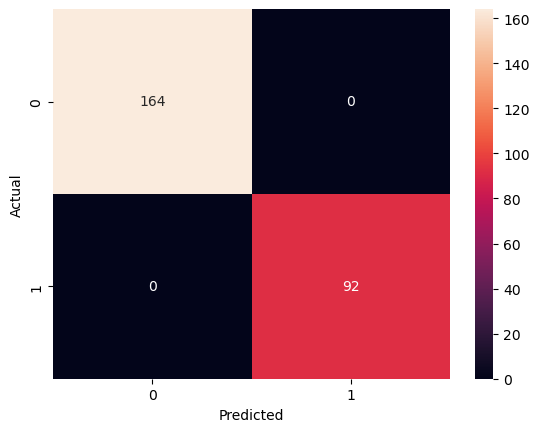

In [60]:
evaluate(grid_searchGBC2.best_estimator_, y_test2, X_test2)

------------------------------
# Third Database Data Engineering Process

Database name: "predict taxi fare.csv"

In [61]:
# Same exact code process as for the first database
df3 = pd.read_csv('predict taxi fare.csv')

In [62]:
df3.head()

,medallion,pickup_datetime,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount
0,4D24F4D8EF35878595044A52B098DFD2,2013-01-13T10:23:00Z,-73.946457,40.772728,600,8.0,2.5
1,A49C37EB966E7B05E69523D1CB7BE303,2013-01-13T04:52:00Z,-73.998268,40.740414,840,18.0,0.0
2,1E4B72A8E623888F53A9693C364AC05A,2013-01-13T10:47:00Z,-73.953461,40.775864,60,3.5,0.7
3,F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13T11:14:00Z,-73.981369,40.724731,720,11.5,2.3
4,A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13T11:24:00Z,-73.967995,40.760002,240,6.5,0.0


## 1.0) Data Preprocessing

##### Droping useless columns

In [63]:
df3.drop(columns=['medallion'], inplace=True)

df3.head()

,pickup_datetime,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount
0,2013-01-13T10:23:00Z,-73.946457,40.772728,600,8.0,2.5
1,2013-01-13T04:52:00Z,-73.998268,40.740414,840,18.0,0.0
2,2013-01-13T10:47:00Z,-73.953461,40.775864,60,3.5,0.7
3,2013-01-13T11:14:00Z,-73.981369,40.724731,720,11.5,2.3
4,2013-01-13T11:24:00Z,-73.967995,40.760002,240,6.5,0.0


##### Taking a sample

In [64]:
# Taking a Random Sample of 8000 rows
df3 = df3.sample(n=8000, random_state=42)
df3.shape

(8000, 6)

##### Feature Extracting, day_in_week & time_in_day

In [65]:
# Extracting the day from the pickup_datetime column
df3['weekday'] = pd.to_datetime(df3['pickup_datetime']).dt.dayofweek

# Extracting the hour, minute from the pickup_datetime column
df3['daytime'] = pd.to_datetime(df3['pickup_datetime']).dt.hour + pd.to_datetime(df3['pickup_datetime']).dt.minute / 60

# Dropping the pickup_datetime column
df3.drop(columns=['pickup_datetime'], inplace=True)

df3.head()

,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount,weekday,daytime
33552,-74.002129,40.741291,720,11.0,2.2,4,7.083333
9427,-73.980492,40.730576,519,7.5,1.0,2,19.700000
199,-73.973190,40.752766,660,8.0,0.0,2,15.700000
12447,-73.973869,40.783012,1020,13.5,0.0,5,18.100000
39488,-73.995956,40.726589,585,8.5,0.0,5,12.433333


##### Checking null values for each column.

In [66]:
# Get the number of null values for each column
null_values = df3.isnull().sum()
print(null_values)

# We have no null values!

pickup_longitude     0
pickup_latitude      0
trip_time_in_secs    0
fare_amount          0
tip_amount           0
weekday              0
daytime              0
dtype: int64


Checking for non numeric data

In [67]:
non_numeric_columns = df3.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

# We have no non-numeric columns!

Index([], dtype='object')


In [68]:
df3.head()

,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount,weekday,daytime
33552,-74.002129,40.741291,720,11.0,2.2,4,7.083333
9427,-73.980492,40.730576,519,7.5,1.0,2,19.700000
199,-73.973190,40.752766,660,8.0,0.0,2,15.700000
12447,-73.973869,40.783012,1020,13.5,0.0,5,18.100000
39488,-73.995956,40.726589,585,8.5,0.0,5,12.433333


## 2.1) Random Forest model implementation

In [69]:
# Split the data into features and target label
X3 = df3.drop('fare_amount', axis=1)
y3 = df3['fare_amount']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [70]:
# Creating a random forest classifier
rfrModel3 = RandomForestRegressor(n_estimators=64, random_state=42, oob_score=True)

rfrModel3.fit(X_train3, y_train3)

rfrPredictions3 = rfrModel3.predict(X_test3)

# Calculate the accuracy of the model
oob_score3 = rfrModel3.oob_score_
print(f'Out-of-Bag Score: {oob_score3}')
 
evaluateRegrission(y_test3, rfrPredictions3)

Out-of-Bag Score: 0.7857191266084633
Mean Squared Error: 14.327860562072756
R-squared: 0.8352348979054396
Mean Absolute Error: 1.6484857421875


## 2.2) Hyperparameter tuning for the Random Forest model

In [71]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridRFR3 = {
    'n_estimators': [64, 128],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfr3 = RandomForestRegressor(random_state=42, oob_score=True)

# Instantiate the grid search model
grid_searchRFR3 = GridSearchCV(estimator=rfr3, param_grid=param_gridRFR3, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchRFR3.fit(X_train3, y_train3)

# Print the best parameters
print(grid_searchRFR3.best_params_)
print(grid_searchRFR3.best_estimator_)
print(grid_searchRFR3.best_score_)


# The results:
# Best Params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 128}
# Classifier: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, n_estimators=128, oob_score=True, random_state=42)
# Score: 0.8180372015629397

Fitting 3 folds for each of 192 candidates, totalling 576 fits


c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
288 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\most2\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 417, in fit
    raise ValueErr

{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 128}
RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=128, oob_score=True, random_state=42)
0.8180372015629397


## 2.3) Evaluation of the Random Forest model

In [72]:
bestRFRModel3 = grid_searchRFR3.best_estimator_

# Evaluating the best model
bestRFRpredection3 =  bestRFRModel3.predict(X_test3)

# Calculate the accuracy of the model
oob_score32 = bestRFRModel3.oob_score_
print(f'Out-of-Bag Score: {oob_score32}')

evaluateRegrission(y_test3, bestRFRpredection3)

Out-of-Bag Score: 0.8206060480979982
Mean Squared Error: 12.8456223600785
R-squared: 0.8522800895181022
Mean Absolute Error: 1.5775214773592048


## 3.1) AdaBoost model implementation

In [73]:
# Creating a AdaBoost classifier
abrModel3 = AdaBoostRegressor(n_estimators=100, random_state=42)

abrModel3.fit(X_train3, y_train3)

abrPredictions3 = abrModel3.predict(X_test3)

# Calculate the accuracy of the model
 
# Evaluating the model
evaluateRegrission(y_test3, abrPredictions3)

Mean Squared Error: 148.19882989795522
R-squared: -0.7042317820336559
Mean Absolute Error: 11.487170690159692


## 3.2) Hyperparameter tuning for the AdaBoost model

In [74]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridABR3 = {
    'n_estimators': [50, 70, 100, 200, 300],
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 1]
}

# Create a base model
abrModel3 = AdaBoostRegressor(random_state=42)

# Instantiate the grid search model
grid_searchABR3 = GridSearchCV(estimator=abrModel3, param_grid=param_gridABR3, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchABR3.fit(X_train3, y_train3)

# Print the best parameters
print(grid_searchABR3.best_params_)
print(grid_searchABR3.best_estimator_)
print(grid_searchABR3.best_score_)


# The results:

# {'learning_rate': 0.01, 'n_estimators': 200}
# AdaBoostRegressor(learning_rate=0.01, n_estimators=200, random_state=42)
# 0.7237371691339942

Fitting 3 folds for each of 35 candidates, totalling 105 fits
{'learning_rate': 0.01, 'n_estimators': 200}
AdaBoostRegressor(learning_rate=0.01, n_estimators=200, random_state=42)
0.7237371691339942


## 3.3) Evaluation of the AdaBoost model

In [75]:
# Evaluating the best model
ABRpredection3 =  grid_searchABR3.best_estimator_.predict(X_test3)
 
# Evaluating the model
evaluateRegrission(y_test3, ABRpredection3)

Mean Squared Error: 20.284462868168887
R-squared: 0.7667361724433429
Mean Absolute Error: 2.8013100044966803


## 4.1) Gradient Boost model implementation

In [76]:
# Creating a Gradient Boost classifier
gbrModel3 = GradientBoostingRegressor(n_estimators=100, random_state=42)

gbrModel3.fit(X_train3, y_train3)

gbrPredictions3 = gbrModel3.predict(X_test3)
 
# Evaluating the model
evaluateRegrission(y_test3, gbrPredictions3)

Mean Squared Error: 12.970903055576857
R-squared: 0.8508394078130536
Mean Absolute Error: 1.6307387979527952


## 4.2) Hyperparameter tuning for the Gradient Boost model

In [77]:
# Hyperparameter tuning using grid search

# Create the parameter grid
param_gridGBR3 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
gbrModel3 = GradientBoostingRegressor(random_state=42, max_features='sqrt')

# Instantiate the grid search model
grid_searchGBR3 = GridSearchCV(estimator=gbrModel3, param_grid=param_gridGBR3, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_searchGBR3.fit(X_train3, y_train3)

# Print the best parameters
print(grid_searchGBR3.best_params_)
print(grid_searchGBR3.best_estimator_)
print(grid_searchGBR3.best_score_)


# The results:

# {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
# GradientBoostingRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
#                           random_state=42)
# 0.8155001581679917

Fitting 3 folds for each of 162 candidates, totalling 486 fits
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoostingRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                          random_state=42)
0.8155001581679917


## 4.3) Evaluation of the Gradient Boost model

In [78]:
# Evaluating the best model
GBRpredection3 =  grid_searchGBR3.best_estimator_.predict(X_test3)
 
# Evaluating the model
evaluateRegrission(y_test3, GBRpredection3)

Mean Squared Error: 12.786441048020755
R-squared: 0.8529606527383429
Mean Absolute Error: 1.6151641794733644


## 5.0) Comparisson Table

In [79]:
# Accuracy Using a table
final_data = {
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boost'],
    'Bankloan': [grid_searchRFC.best_score_, grid_searchABC.best_score_, grid_searchGBC.best_score_],
    'DataBanknote': [grid_searchRFC2.best_score_, grid_searchABC2.best_score_, grid_searchGBC2.best_score_],
    'TaxiFare': [grid_searchRFR3.best_score_, grid_searchABR3.best_score_, grid_searchGBR3.best_score_]
}

df = pd.DataFrame(final_data)
print(df)

            Model  Bankloan  DataBanknote  TaxiFare
0   Random Forest  0.985499      0.992191  0.818037
1        AdaBoost  0.966251      0.997070  0.723737
2  Gradient Boost  0.986000      0.998048  0.815500


## 6.0) Visualization.

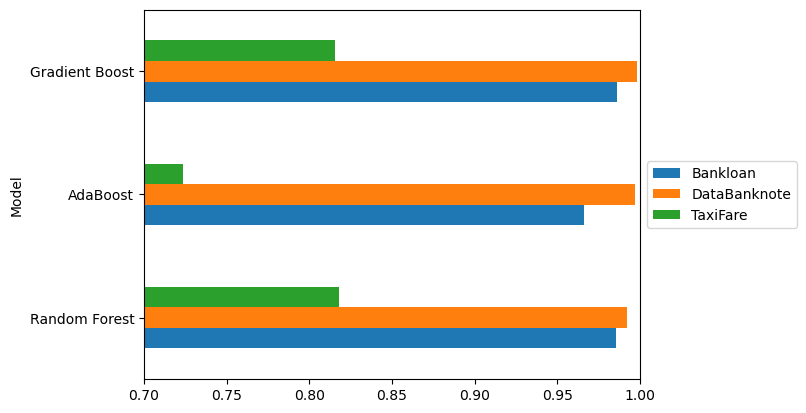

In [106]:
# Bar Charting the final_data in the same figure
df.plot(kind='barh', x='Model', y=['Bankloan', 'DataBanknote', 'TaxiFare'])
plt.subplots_adjust(wspace=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim(0.7, 1)

plt.show()

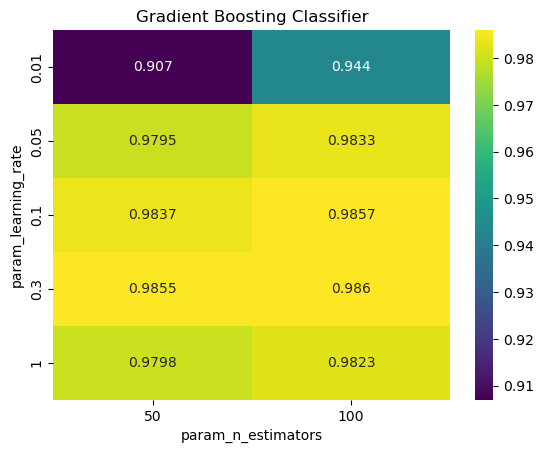

In [147]:
results1 = pd.DataFrame(grid_searchGBC.cv_results_)
results1 = results1.sort_values(by='mean_test_score', ascending=False)
results1 = results1[['param_learning_rate', 'param_n_estimators', 'mean_test_score']]
results1 = results1.drop_duplicates(subset=['param_learning_rate', 'param_n_estimators'])
results1 = results1.pivot(index='param_learning_rate', columns= 'param_n_estimators', values='mean_test_score')
sns.heatmap(results1, annot=True, fmt='.4g', cmap='viridis')
plt.title('Gradient Boosting Classifier')
plt.show()

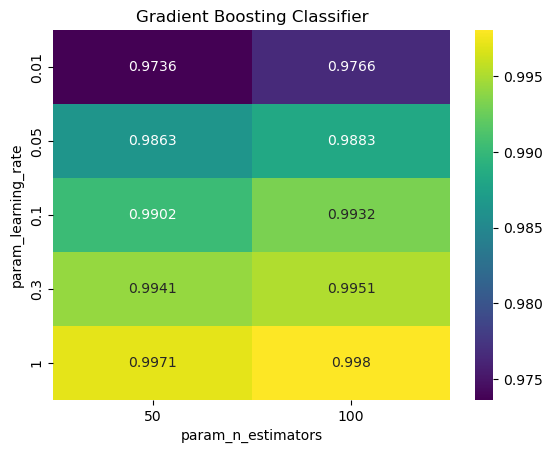

In [148]:
results2 = pd.DataFrame(grid_searchGBC2.cv_results_)
results2 = results2.sort_values(by='mean_test_score', ascending=False)
results2 = results2[['param_learning_rate', 'param_n_estimators', 'mean_test_score']]
results2 = results2.drop_duplicates(subset=['param_learning_rate', 'param_n_estimators'])
results2 = results2.pivot(index='param_learning_rate', columns= 'param_n_estimators', values='mean_test_score')
sns.heatmap(results2, annot=True, fmt='.4g', cmap='viridis')
plt.title('Gradient Boosting Classifier')
plt.show()

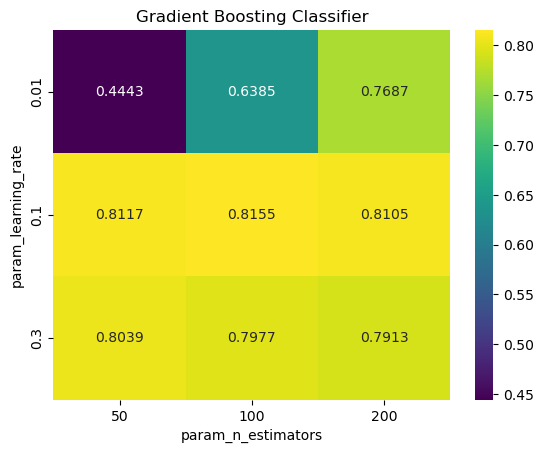

In [149]:
results3 = pd.DataFrame(grid_searchGBR3.cv_results_)
results3 = results3.sort_values(by='mean_test_score', ascending=False)
results3 = results3[['param_learning_rate', 'param_n_estimators', 'mean_test_score']]
results3 = results3.drop_duplicates(subset=['param_learning_rate', 'param_n_estimators'])
results3 = results3.pivot(index='param_learning_rate', columns= 'param_n_estimators', values='mean_test_score')
sns.heatmap(results3, annot=True, fmt='.4g', cmap='viridis')
plt.title('Gradient Boosting Classifier')
plt.show()

## 7.0) Insight and Conslusion.

### Bankloan Dataset

Model Performance:

Random Forest: Achieved high accuracy (0.985499).

AdaBoost: High accuracy (0.966251).

Gradient Boost: High accuracy (0.986000).


<br>


Reasons:

Strengths: All three models are well-suited for classification tasks where the goal is to predict binary outcomes (0 or 1).

Dataset Characteristics: The Bankloan dataset likely has well-defined patterns that these models can exploit for accurate predictions.




<br>
<br>
<br>
<br>


### DataBanknote Dataset

Model Performance:

Random Forest: Very high accuracy (0.992191).

AdaBoost: Very high accuracy (0.997070).

Gradient Boost: Excellent accuracy (0.998048).

<br>


Reasons:

Strengths: Ensemble methods excel in handling complex patterns and relationships in the data.

Dataset Characteristics: The DataBanknote dataset may have distinct and separable features, allowing ensemble models to achieve high accuracy.




<br>
<br>
<br>
<br>




### TaxiFare Dataset

Model Performance:

Random Forest: Moderate accuracy (0.818037).

AdaBoost: Lower accuracy (0.723737).

Gradient Boost: Moderate accuracy (0.815500).


<br>


Reasons:

Challenges: The TaxiFare dataset involves regression, predicting a continuous numeric value (fare amount) rather than a binary outcome.

Weaknesses: Ensemble models might not perform as well in regression tasks compared to classification tasks.

Dataset Characteristics: The regression nature of the task and the need to predict precise numeric values could pose challenges. The random sample from the large dataset might introduce some variability.




<br>
<br>
<br>
<br>


#### General Insights & Conclusions

Model Adaptability: Gradient Boost, despite being a boosting algorithm often used for regression, still faces challenges in the regression task. It might require more nuanced hyperparameter tuning for improved performance.

Data Size: The decision to take a random sample from the TaxiFare dataset might introduce variability. The larger dataset might provide more diverse patterns for the models to learn.



<br>
<br>
<br>
<br>
